# Пайплайн для выделения лучших кропов по текстовому запросу Yolo -> Clip -> Annoy

Все расчеты ниже получены по **valid** выборке датасета LVIS

* Применяем модель YoloV5L к датасету, получаем кропы для картинок
* Применяем модель clip к каждому кропу, получаем эмбеддинги кропов
* Применяем модель clip к описанию категорий датасета LVIS, получаем эмбеддинги категорий
* Строим индекс annoy по эмбеддингам кропов для поиска ближайших соседей из кропов к каждой категории датасета
* Проводим анализ метрик

В дальнейшем полученный индекс annoy будет использоваться в ДЕМО для поиска подходящих кропов (из valid части датасета LVIS) для текстового запроса пользователя

In [39]:
import sys

sys.path.append("../yolov5")

In [40]:
from assh_utils import Batch, get_iou, load_json, nms

In [41]:
from yolo_utils import CustomWrapper, DetectMultiBackend

In [42]:
import os

root = "/home/jupyter/mnt/s3/asciishell-fsod/LVIS/"
js = load_json("/home/jupyter/mnt/s3/asciishell-fsod/LVIS/lvis_v1_val.json.zip")
images = [root + x["coco_url"].replace("http://images.cocodataset.org/", "") for x in js["images"]]
assert all([os.path.exists(x) for x in images[:100]])

In [43]:
import itertools
import math
import os
import pickle

import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
from annoy import AnnoyIndex
from sklearn.cluster import KMeans
from sklearn.metrics import average_precision_score
from tqdm.cli import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## Применяем модель YoloV5L с KMeans + NMS
Сохраняем датафрейм с картинками и соответствующими кропами.

In [6]:
model = CustomWrapper(DetectMultiBackend("./yolov5l.pt", device="cuda"))

Fusing layers... 
Model Summary: 367 layers, 46533693 parameters, 0 gradients
Adding AutoShape... 


In [7]:
results = []
for names in tqdm(Batch(images, 32)):
    pack = names.copy()
    res = model(pack)
    for im, df in zip(names, res.pandas().xyxy):
        if not len(df):
            continue
        kmeans = KMeans(n_clusters=max(min(30, len(df) // 2), 1), random_state=0, verbose=0).fit(
            df[["xmin", "ymin", "xmax", "ymax"]]
        )
        df["labels"] = kmeans.labels_
        df["image"] = im
        for label in df["labels"].unique():
            match = df[df["labels"] == label]
            keep = nms(match[["xmin", "ymin", "xmax", "ymax"]].values, match["confidence"].values, 0.45, max_dets=10)
            results.extend(match.iloc[keep].to_dict("records"))
results = pd.DataFrame(results)
results.to_pickle(f"/home/jupyter/mnt/s3/asciishell-fsod/RunYoloV2/valid.pkl.zip")

100%|██████████| 620/620 [1:40:58<00:00,  9.77s/it]


In [8]:
results.head()

,xmin,ymin,xmax,ymax,confidence,class,name,labels,image
0,40.971844,0.000000,60.881138,25.069565,0.035634,44,spoon,21,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...
1,73.472641,0.000000,88.623871,65.664429,0.015488,44,spoon,21,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...
2,42.971092,0.000000,61.029366,10.111710,0.012637,44,spoon,21,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...
3,188.240448,26.259232,205.060364,47.306900,0.035532,44,spoon,16,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...
4,215.844727,17.311447,226.152100,47.575546,0.034705,44,spoon,16,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...


Округляем границы bbox. Удаяем слишком маленькие кропы и дубликаты. Сохраняем отсортированный и сокращенный датафрейм с картинками и кропами.

In [9]:
dfs = pd.read_pickle("/home/jupyter/mnt/s3/asciishell-fsod/RunYoloV2/valid.pkl.zip")
dfs[["xmin", "ymin", "xmax", "ymax"]] = dfs[["xmin", "ymin", "xmax", "ymax"]].round().astype(np.int32).values
dfs = dfs[((dfs["xmin"] - dfs["xmax"]).abs() > 5) & ((dfs["ymin"] - dfs["ymax"]).abs() > 5)]
dfs = (
    dfs.sort_values(["image"])
    .drop_duplicates(["xmin", "ymin", "xmax", "ymax", "image"], keep="first")
    .sort_values(["image", "confidence", "xmin", "ymin", "xmax", "ymax"])
    .reset_index(drop=True)
)
dfs.to_pickle("/home/jupyter/mnt/s3/asciishell-fsod/RunYoloV2/valid.sorted.pkl.zip")
dfs

,xmin,ymin,xmax,ymax,confidence,class,name,labels,image
0,168,13,433,238,0.012927,45,bowl,21,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...
1,449,29,595,193,0.013515,49,orange,10,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...
2,401,204,604,480,0.015962,45,bowl,2,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...
3,358,13,478,115,0.018738,49,orange,22,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...
4,312,0,395,57,0.018925,49,orange,25,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...
...,...,...,...,...,...,...,...,...,...
852826,0,188,132,342,0.718746,46,banana,24,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...
852827,208,379,450,440,0.817313,46,banana,12,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...
852828,133,216,427,315,0.846618,46,banana,1,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...
852829,201,186,428,247,0.847813,46,banana,1,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...


## Применяем модель clip к каждому кропу

Сохраняем полученные эмбеддинги для каждого кропа и датафрейм с картинками и кропами в соответствующем порядке.

In [10]:
clip_model, clip_preprocess = clip.load("/home/jupyter/mnt/s3/asciishell-fsod/models/ViT-B-32.pt", device)

In [11]:
embeddings = []
images = []
for index, row in tqdm(dfs.groupby("image")):
    img = PIL.Image.open(index)
    for _, row2 in row.iterrows():
        img_crop = img.crop(box=row2[["xmin", "ymin", "xmax", "ymax"]].values)
        image_input = clip_preprocess(img_crop).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = clip_model.encode_image(image_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        embeddings.append(image_features[0].cpu().numpy())
        images.append(row2.to_dict())
embeddings = np.stack(embeddings)
images = pd.DataFrame(images)
np.save("/home/jupyter/mnt/s3/asciishell-fsod/RunYoloV2/valid_emb.npy", embeddings)
images.to_pickle("/home/jupyter/mnt/s3/asciishell-fsod/RunYoloV2/valid.done.pkl.zip")

100%|██████████| 19790/19790 [3:57:25<00:00,  1.39it/s]


In [6]:
embeddings = np.load("/home/jupyter/mnt/s3/asciishell-fsod/RunYoloV2/valid_emb.npy")
images = pd.read_pickle("/home/jupyter/mnt/s3/asciishell-fsod/RunYoloV2/valid.done.pkl.zip")

In [7]:
embeddings.shape

(852831, 512)

## Получим эмбеддинг для определения каждой категории датасета LVIS
Сохраним категорию и соответствующий ей эмбеддинг.

In [5]:
def get_vector_text(x):
    text_inputs = torch.cat([clip.tokenize(x)]).to(device)
    with torch.no_grad():
        text_features = clip_model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features[0].cpu().numpy()


def get_vector_image(x):
    img = PIL.Image.open(x)
    img.thumbnail((640, 640), PIL.Image.ANTIALIAS)
    img.show()
    image_input = clip_preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features[0].cpu().numpy()

In [8]:
categories_emb = []
categories = []
for category in tqdm(js["categories"]):
    categories_emb.append(get_vector_text(category["def"]))
    categories.append(category)
categories_emb = np.stack(categories_emb)
categories = pd.DataFrame(categories)
np.save("/home/jupyter/mnt/s3/asciishell-fsod/RunYolo/categories_emb.npy", categories_emb)
categories.to_pickle("/home/jupyter/mnt/s3/asciishell-fsod/RunYolo/categories.pkl.zip")

In [44]:
categories_emb = np.load("/home/jupyter/mnt/s3/asciishell-fsod/RunYolo/categories_emb.npy")
categories = pd.read_pickle("/home/jupyter/mnt/s3/asciishell-fsod/RunYolo/categories.pkl.zip")

## Для эмбеддинга каждой категории найдем n ближайших соседей из эмбеддингов кропов

In [9]:
t = AnnoyIndex(embeddings.shape[1], "angular")
for i, v in enumerate(embeddings):
    t.add_item(i, v)
t.build(100)
t.save("/home/jupyter/mnt/s3/asciishell-fsod/RunYoloV2/valid_100.ann")

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: t
  warnings.warn(message)


True

In [45]:
t = AnnoyIndex(512, "angular")
t.load("/home/jupyter/mnt/s3/asciishell-fsod/RunYoloV2/valid_100.ann")

True

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: t
  warnings.warn(message)


## Проводим анализ метрик
Определим, относятся ли в действительности выделенные кропы к заданной категории (с помощью iou) и вычислим метрики качества.

In [ ]:
metrics = []
annotation = pd.DataFrame(js['annotations'])
for index, category in tqdm(categories.iterrows(), total=categories.shape[0]):
    best = t.get_nns_by_vector(categories_emb[index], 30, search_k=-1, include_distances=True) # сколько есть максимально объектов каждой категории:
    x_conf = images.loc[best[0], 'confidence']
    tp = []
    x_iou = []
    for x in best[0]: # имеет ли смысл убрать кропы с одной картинки с большим iou?
        img = images.loc[x]
        for ann in annotation[annotation['image_id'] == int(img['image'][-16:-4])].iterrows():
            ann = ann[1]
            iou = get_iou({'x1': img['xmin'], 'x2': img['xmax'], 'y1': img['ymin'], 'y2': img['ymax']}, 
                    {'x1': ann['bbox'][0], 'x2': ann['bbox'][0] + ann['bbox'][2], 'y1': ann['bbox'][1], 'y2': ann['bbox'][1] + ann['bbox'][3]})
            if iou > 0.5 and ann['category_id'] == category['id']: # стоит ли рассматривать разные iou?
                x_iou.append(iou)
                tp.append(1)
                break
        else:
            x_iou.append(None)
            tp.append(0)
            
    for n_neighb in [1, 5, 10, 20, 30]: 
        metrics.append({
                        'category_id': category['id'], 
                        'category_name': category['name'],
                        'n_neighb': n_neighb,
                        'average_precision_conf': average_precision_score(tp[:n_neighb], x_conf[:n_neighb]),
                        'average_precision_dist': average_precision_score(tp[:n_neighb], 1 / np.array(best[1][:n_neighb])),
                        'average_precision_multi': average_precision_score(tp[:n_neighb], np.array(x_conf[:n_neighb]) / np.array(best[1][:n_neighb])),
                        'tp': np.sum(tp[:n_neighb]),
                        'dist_mean': np.mean(best[1][:n_neighb]), 
                        'conf_mean': np.mean(x_conf[:n_neighb]), 
                        'iou_mean': np.mean([x for x in x_iou[:n_neighb] if x is not None], dtype=np.float64), 
                       })
    
metrics = pd.DataFrame(metrics)
metrics.to_pickle('/home/jupyter/mnt/s3/asciishell-fsod/RunYoloV2/valid_metrics_100.pkl.zip')

In [88]:
metrics = pd.read_pickle("/home/jupyter/mnt/s3/asciishell-fsod/RunYoloV2/valid_metrics_100.pkl.zip")

In [89]:
metrics["accuracy"] = metrics["tp"] / metrics["n_neighb"]

In [90]:
metrics.head()

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,...,tp,dist_mean,conf_mean,iou_mean,accuracy
0,1,aerosol_can,1,NaN,NaN,...,0,1.139319,0.022353,NaN,0.0
1,1,aerosol_can,5,NaN,NaN,...,0,1.147435,0.020082,NaN,0.0
2,1,aerosol_can,10,NaN,NaN,...,0,1.154267,0.029361,NaN,0.0
3,1,aerosol_can,20,NaN,NaN,...,0,1.160309,0.210208,NaN,0.0
4,1,aerosol_can,30,NaN,NaN,...,0,1.163329,0.260706,NaN,0.0


In [91]:
# в топе по accuracy простые и понятные категории (животные, популярные предметы)
metrics_ = metrics[metrics["n_neighb"] == 10]
metrics_.sort_values("accuracy", ascending=False).head(10)

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,...,tp,dist_mean,conf_mean,iou_mean,accuracy
4612,923,scissors,10,1.000000,1.000000,...,10,1.146868,0.345915,0.892235,1.0
287,58,baseball_bat,10,1.000000,1.000000,...,10,1.127721,0.290813,0.908552,1.0
2842,569,horse,10,1.000000,1.000000,...,10,1.163779,0.491670,0.964046,1.0
2107,422,elephant,10,1.000000,1.000000,...,10,1.141153,0.314772,0.862263,1.0
2222,445,fireplug,10,1.000000,1.000000,...,10,1.134092,0.319265,0.876022,1.0
177,36,suitcase,10,0.878263,0.962654,...,9,1.148453,0.309789,0.841872,0.9
222,45,banana,10,0.976543,0.946781,...,9,1.160376,0.185451,0.709723,0.9
1477,296,computer_keyboard,10,1.000000,1.000000,...,9,1.136631,0.535823,0.882941,0.9
1932,387,doughnut,10,1.000000,1.000000,...,9,1.138734,0.347408,0.769682,0.9
2477,496,giraffe,10,0.946781,0.988889,...,9,1.152754,0.310091,0.884805,0.9


In [92]:
# не угадываем редкие для человека объекты
metrics_.sort_values("accuracy").head(10)

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,...,tp,dist_mean,conf_mean,iou_mean,accuracy
2,1,aerosol_can,10,NaN,NaN,...,0,1.154267,0.029361,NaN,0.0
3822,765,parka,10,NaN,NaN,...,0,1.187802,0.437488,NaN,0.0
3832,767,parrot,10,NaN,NaN,...,0,1.195003,0.160515,NaN,0.0
3837,768,passenger_car_(part_of_a_train),10,NaN,NaN,...,0,1.157370,0.372585,NaN,0.0
3842,769,passenger_ship,10,NaN,NaN,...,0,1.188015,0.324319,NaN,0.0
3857,772,patty_(food),10,NaN,NaN,...,0,1.201798,0.377343,NaN,0.0
3862,773,pea_(food),10,NaN,NaN,...,0,1.183117,0.362527,NaN,0.0
3867,774,peach,10,NaN,NaN,...,0,1.169759,0.377657,NaN,0.0
3872,775,peanut_butter,10,NaN,NaN,...,0,1.167844,0.077410,NaN,0.0
3882,777,peeler_(tool_for_fruit_and_vegetables),10,NaN,NaN,...,0,1.161623,0.137640,NaN,0.0


In [93]:
# 1203 * 6 - всего экспериментов
metrics.shape[0]

6015

In [94]:
# у нас много редких категорий
ann = annotation["category_id"].value_counts()
ann

45     9156
127    7022
217    3762
12     3116
827    2724
       ... 
532       1
251       1
619       1
803       1
238       1
Name: category_id, Length: 1035, dtype: int64

In [95]:
# проведем анализ для меньшего числа категорий
len(ann[ann > 100])

327

In [96]:
# общее количество экспериментов
metrics[metrics["category_id"].isin(ann[ann > 100].index)].shape[0]

1635

In [1]:
# общее количество экспериментов с ненулевым tp
q = metrics[(metrics["tp"] != 0) & metrics["category_id"].isin(ann[ann > 100].index)].shape[0]
q, q / 1635

(512, 0.3131498470948012)

In [2]:
# число категорий по которым нет верных ответов
q = metrics[
    (metrics["tp"] == 0) & (metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)
].shape[0]
q, q / 327

(215, 0.6574923547400612)

In [99]:
# среднее количество верных ответов для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("n_neighb")["tp"].mean()

n_neighb
1     0.125382
5     0.648318
10    1.269113
20    2.336391
30    3.455657
Name: tp, dtype: float64

In [100]:
# среднее количество верных ответов для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].groupby("n_neighb")["tp"].mean()

n_neighb
1     0.027778
5     0.205556
10    0.327778
20    0.522222
30    0.672222
Name: tp, dtype: float64

In [101]:
metrics[metrics["category_id"].isin(ann[ann > 100].index)].fillna(0).groupby("n_neighb")[
    "average_precision_conf"
].mean()

n_neighb
1     0.125382
5     0.181358
10    0.183457
20    0.171777
30    0.159188
Name: average_precision_conf, dtype: float64

In [102]:
metrics[metrics["category_id"].isin(ann[ann > 100].index)].fillna(0).groupby("n_neighb")[
    "average_precision_dist"
].mean()

n_neighb
1     0.125382
5     0.172396
10    0.176702
20    0.173906
30    0.169108
Name: average_precision_dist, dtype: float64

In [103]:
metrics[metrics["category_id"].isin(ann[ann > 100].index)].fillna(0).groupby("n_neighb")[
    "average_precision_multi"
].mean()

n_neighb
1     0.125382
5     0.180951
10    0.183666
20    0.171459
30    0.160281
Name: average_precision_multi, dtype: float64

In [104]:
len(ann[(ann >= 30) & (ann <= 100)])

180

In [105]:
metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)][
    "average_precision_conf"
].isna().mean()

0.6574923547400612

In [106]:
metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)][
    "average_precision_conf"
].isna().mean()

0.8722222222222222

In [107]:
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].fillna(0).groupby("n_neighb")[
    "average_precision_conf"
].mean()

n_neighb
1     0.027778
5     0.065633
10    0.053159
20    0.040632
30    0.038637
Name: average_precision_conf, dtype: float64

In [108]:
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].fillna(0).groupby("n_neighb")[
    "average_precision_dist"
].mean()

n_neighb
1     0.027778
5     0.061057
10    0.064242
20    0.063762
30    0.061473
Name: average_precision_dist, dtype: float64

In [109]:
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].fillna(0).groupby("n_neighb")[
    "average_precision_multi"
].mean()

n_neighb
1     0.027778
5     0.065015
10    0.052653
20    0.040551
30    0.038972
Name: average_precision_multi, dtype: float64

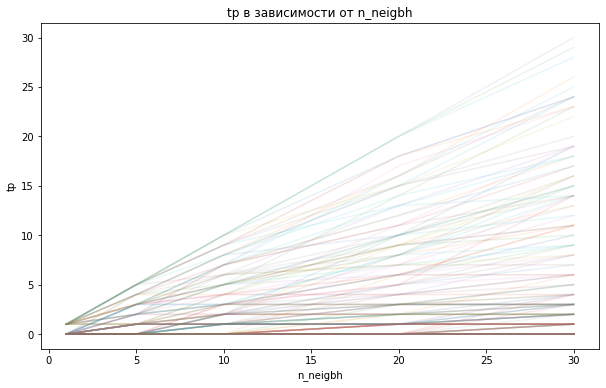

In [110]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["tp"], alpha=0.1)
plt.plot()
plt.title("tp в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("tp")
plt.show()

In [111]:
# средняя accuracy для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("n_neighb")["accuracy"].mean()

n_neighb
1     0.125382
5     0.129664
10    0.126911
20    0.116820
30    0.115189
Name: accuracy, dtype: float64

In [112]:
# средняя accuracy для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].groupby("n_neighb")["accuracy"].mean()

n_neighb
1     0.027778
5     0.041111
10    0.032778
20    0.026111
30    0.022407
Name: accuracy, dtype: float64

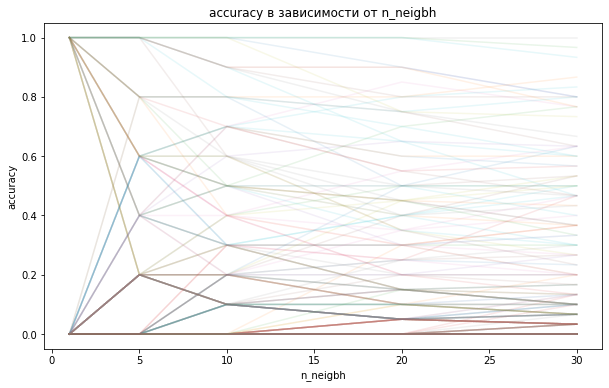

In [113]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["accuracy"], alpha=0.1)
plt.plot()
plt.title("accuracy в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("accuracy")
plt.show()

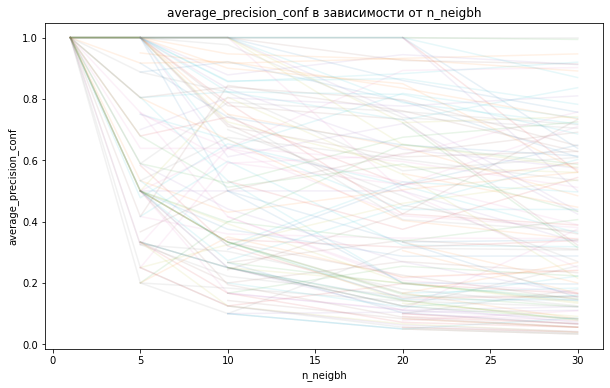

In [114]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["average_precision_conf"], alpha=0.1)
plt.plot()
plt.title("average_precision_conf в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("average_precision_conf")
plt.show()

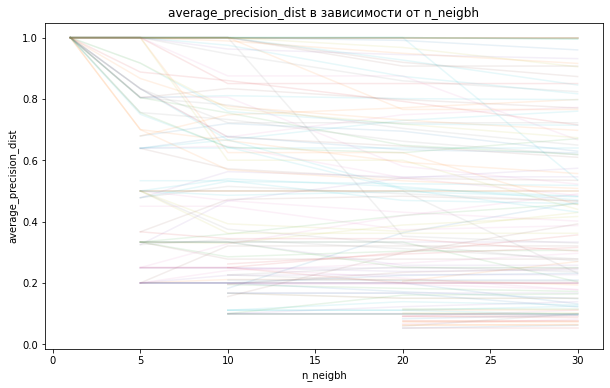

In [115]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["average_precision_dist"], alpha=0.1)
plt.plot()
plt.title("average_precision_dist в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("average_precision_dist")
plt.show()

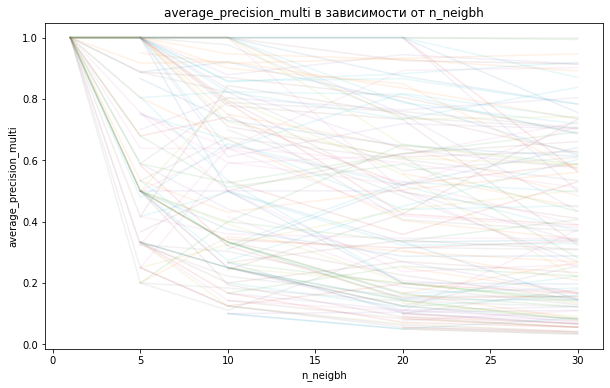

In [116]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["average_precision_multi"], alpha=0.1)
plt.plot()
plt.title("average_precision_multi в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("average_precision_multi")
plt.show()

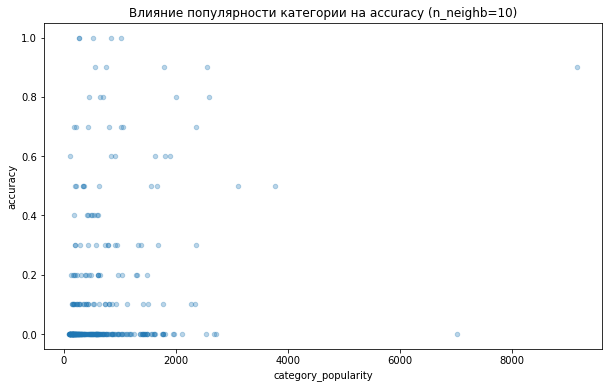

In [117]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)]
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .plot(
        "category_popularity",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на accuracy (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

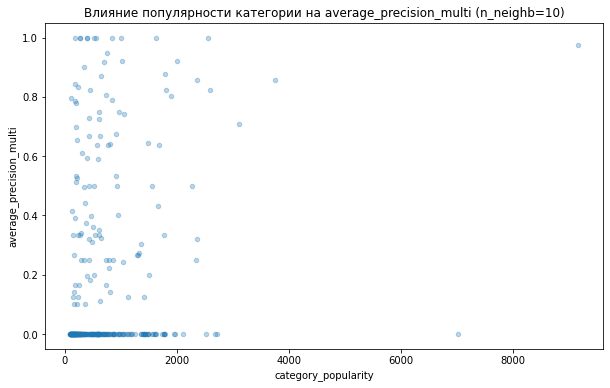

In [118]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)]
    .fillna(0)
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .plot(
        "category_popularity",
        "average_precision_multi",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на average_precision_multi (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

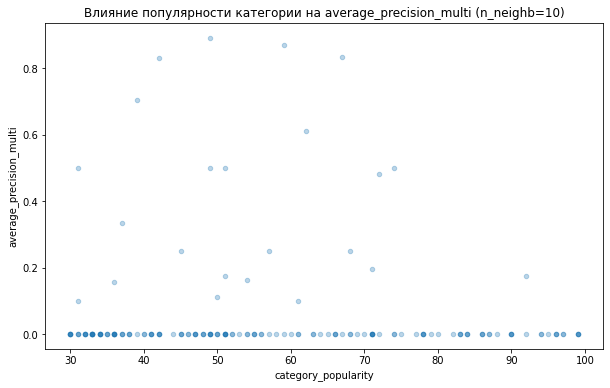

In [119]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)]
    .fillna(0)
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .plot(
        "category_popularity",
        "average_precision_multi",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на average_precision_multi (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

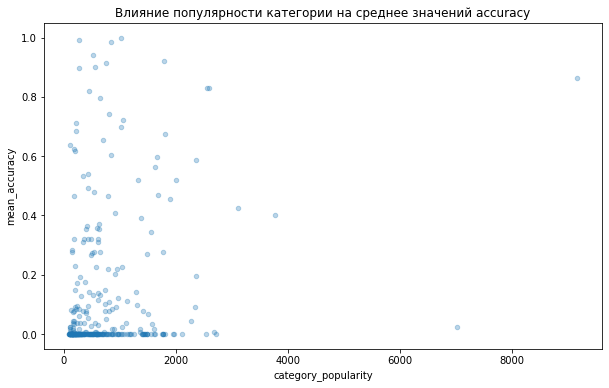

In [120]:
(
    metrics[metrics["category_id"].isin(ann[ann > 100].index)]
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .groupby(["category_id", "category_popularity"])["accuracy"]
    .mean()
    .reset_index(name="mean_accuracy")
    .plot(
        "category_popularity",
        "mean_accuracy",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на среднее значений accuracy",
        figsize=(10, 6),
    )
)
plt.show()

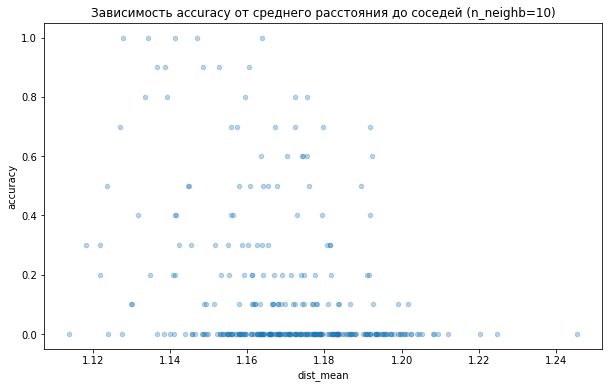

In [121]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].plot(
        "dist_mean",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Зависимость accuracy от среднего расстояния до соседей (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

In [122]:
# top категорий по минимальному расстоянию до соседей (что хорошо знает clip)
metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].sort_values("dist_mean").head(
    10
)

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,...,tp,dist_mean,conf_mean,iou_mean,accuracy
5097,1020,brake_light,10,NaN,NaN,...,0,1.113836,0.294795,NaN,0.0
5392,1079,tennis_racket,10,0.638889,0.240741,...,3,1.118026,0.500165,0.919541,0.3
4822,965,ski_boot,10,0.302778,0.722222,...,3,1.121719,0.241687,0.658212,0.3
6007,1202,zebra,10,0.242857,0.155556,...,2,1.121819,0.214801,0.746795,0.2
4877,976,snowboard,10,0.900000,0.568889,...,5,1.123646,0.302438,0.923947,0.5
3132,627,lamppost,10,NaN,NaN,...,0,1.123751,0.463197,NaN,0.0
3827,766,parking_meter,10,0.844104,0.675680,...,7,1.126993,0.373304,0.798834,0.7
5622,1125,trunk,10,NaN,NaN,...,0,1.127363,0.432353,NaN,0.0
287,58,baseball_bat,10,1.000000,1.000000,...,10,1.127721,0.290813,0.908552,1.0
4832,967,ski_pole,10,0.200000,0.111111,...,1,1.129862,0.051390,0.680068,0.1


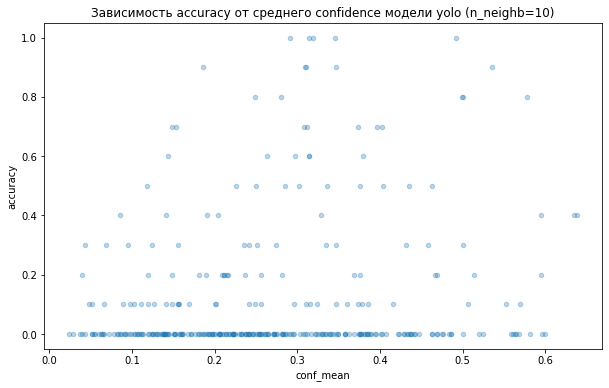

In [123]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].plot(
        "conf_mean",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Зависимость accuracy от среднего confidence модели yolo (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

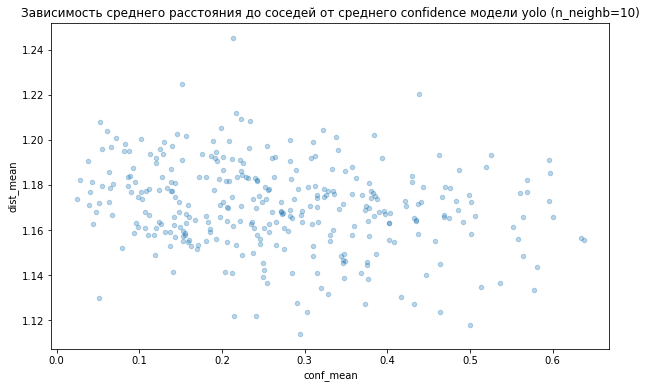

In [124]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].plot(
        "conf_mean",
        "dist_mean",
        kind="scatter",
        alpha=0.3,
        title="Зависимость среднего расстояния до соседей от среднего confidence модели yolo (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

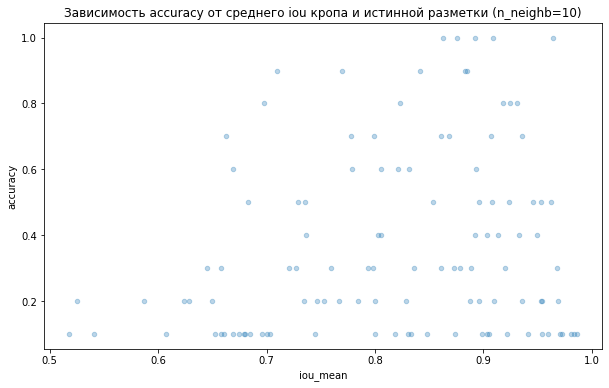

In [125]:
(
    metrics[
        (metrics["tp"] != 0) & (metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)
    ].plot(
        "iou_mean",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Зависимость accuracy от среднего iou кропа и истинной разметки (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()